In [93]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.describe()

,Unnamed: 0
count,2142.000000
mean,1070.500000
std,618.486459
min,0.000000
25%,535.250000
50%,1070.500000
75%,1605.750000
max,2141.000000


In [5]:
train.columns

Index(['Unnamed: 0', 'description_x', 'description_y', 'ticker_x', 'ticker_y',
       'same_security'],
      dtype='object')

<BarContainer object of 2 artists>

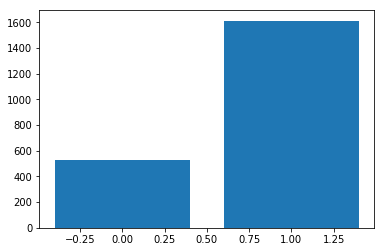

In [98]:
cnts = train['same_security'].value_counts()
plt.bar(cnts.index, cnts.values)

In [6]:
train.head()

,Unnamed: 0,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


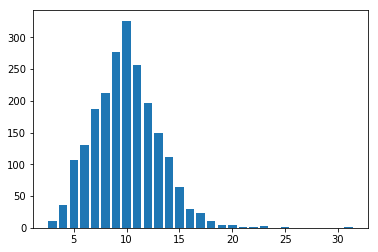

<BarContainer object of 97 artists>

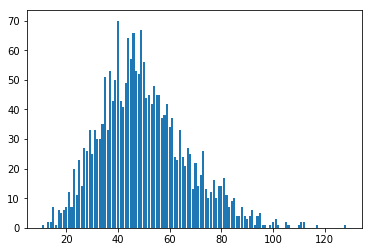

In [135]:
train['xy'] = train['description_x'] +' ' +  train['description_y']
train['word_counts'] = train['xy'].apply(lambda x: len(x.split()))
train['char_counts'] = train['xy'].apply(lambda x: len(x.replace(' ', '')))
texts_counts = train['word_counts'].value_counts()
char_counts = train['char_counts'].value_counts()
plt.bar(texts_counts.index, texts_counts.values)
plt.show()
plt.bar(char_counts.index, char_counts.values)

In [7]:
test.head()

,test_id,description_x,description_y,same_security
0,0,semtech corp,semtech corporation,NaN
1,1,vanguard mid cap index,vanguard midcap index - a,NaN
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN
3,3,vanguard total bond index adm,vanguard total bond market index,NaN
4,4,oakmark international fund class i,oakmark international cl i,NaN


In [8]:
test.describe()

,test_id,same_security
count,516.000000,0.0
mean,257.500000,NaN
std,149.100637,NaN
min,0.000000,NaN
25%,128.750000,NaN
50%,257.500000,NaN
75%,386.250000,NaN
max,515.000000,NaN


In [136]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.svm import SVC
import re

In [114]:
lasso = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1,3)), Lasso(alpha=1.0))
linrgr = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1,3)), LinearRegression())
ridge = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1,3)), Ridge())

In [115]:
def prepare(text):
    text = text.lower()
    text = re.sub(r"[\)]+", ')', text)
    text = re.sub(r"[\(]+", '(', text)
    text = re.sub(r"[ ]([0-9])[ ]", ' ', text)
    text = re.sub(r"(?:http.+)([ ]|$)+", ' ', text)
    return text

In [116]:
X = train.drop(['Unnamed: 0', 'same_security', 'ticker_x', 'ticker_y'], axis=1)
X['data'] = X['description_x'] + X['description_y']
X = X['data'].apply(prepare)
y = train['same_security'].apply(lambda x: 1 if x else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
lasso.fit(X_train, y_train)
linrgr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [118]:
lasso_pred = lasso.predict(X_test)
linrgr_pred = linrgr.predict(X_test)
ridge_pred = ridge.predict(X_test)

In [119]:
#print(f1_score(y_test, y_predicted))
print(roc_auc_score(y_test, lasso_pred))
print(roc_auc_score(y_test, linrgr_pred))
print(roc_auc_score(y_test, ridge_pred))

0.5
0.890489334333798
0.9488021224139779


In [131]:
from xgboost import XGBClassifier
xgb = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1,3)), XGBClassifier(n_estimators=200, n_jobs=-1))
xgb_ch = make_pipeline(TfidfVectorizer(analyzer='char', ngram_range=(1,8)), XGBClassifier(n_estimators=200, n_jobs=-1))

In [132]:
xgb.fit(X_train, y_train)
xgb_ch.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 8), norm='l2', preprocessor=None, smooth...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

In [133]:
xgb_pred = xgb.predict(X_test)
xgb_hpred = xgb_ch.predict(X_test)
print(roc_auc_score(y_test, xgb_pred))
print(roc_auc_score(y_test, xgb_hpred))

0.8449994640368743
0.8923853038910923


In [137]:
poly = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1, 3)), SVC(kernel='poly'))
rbf = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1, 3)), SVC(kernel='rbf'))

In [138]:
poly.fit(X_train, y_train)
rbf.fit(X_train, y_train)

/home/ovchinnikov_dk/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [139]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
print(roc_auc_score(y_test, poly_pred))
print(roc_auc_score(y_test, rbf_pred))

0.5
0.5


In [140]:
test.columns

Index(['test_id', 'description_x', 'description_y', 'same_security'], dtype='object')

In [152]:
test['data'] = test['description_x'] + test['description_y']
test['data'] = test['data'].apply(prepare)
test['same_security'] = ridge.predict(test['data'])

In [153]:
test['same_security'] = test['same_security'].apply(lambda x: x >= 0.5)

In [154]:
test['same_security'].describe()

count      516
unique       2
top       True
freq       390
Name: same_security, dtype: object

In [155]:
result = test.drop(['description_x', 'description_y'], axis=1)

In [156]:
result.to_csv('test_answer.csv')